<a href="https://colab.research.google.com/github/Fabio2394/text_mining/blob/main/Ejercicio1_clasificacion_alumno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
!pip install datasets
!pip install evaluate
!pip install fsspec==2023.9.2


⚙️ **Requerimientos importantes sobre el ejercicio**

- El notebook debe ejecutarse **de principio a fin sin intervención manual**.
- Si utilizas librerías que no están incluidas por defecto en Google Colab, **asegúrate de instalarlas dentro del notebook** (por ejemplo: `!pip install ...`).

- Algunas celdas incluyen identificadores especiales que indican ciertas normas que **debes** respetar:
 - `#NO-MODIFY: DATA LOAD`  
    🔒 **No modifiques** el contenido de esta celda.

  - `#NO-MODIFY: VARIABLE NAME`  
    ✏️ Puedes modificar o añadir información **dentro de la celda**, pero **sin cambiar el nombre de la variable asignada**. No incluyas más variables de las existentes en la celda.

  - `#MODIFY: ADD INFO TO SOLVE FUNCTION`  
    🔧 Puedes modificar el **interior de la función** para resolver la tarea, pero **no cambies su nombre, la cabecera ni el `return`**.



## Imports

In [56]:
import numpy as np
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
# Add your imports here
from wordcloud import WordCloud
from nltk.corpus import stopwords
import pandas as pd
from tqdm import tqdm
from nltk.tokenize import TweetTokenizer
import spacy

# 🔍 Ejercicio1: Detección de profesiones en tweets

## Enunciado

En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Utilizaremos un subconjunto de los datos de la tarea 1 del shared task [**ProfNER**](https://temu.bsc.es/smm4h-spanish), centrada en la detección de menciones a profesiones en tweets publicados durante la pandemia del COVID-19. El objetivo original de la tarea era analizar que profesiones podrían haber sido especialmente vulnerables en el contexto de la crisis sanitaria.

Para simplificar el ejercicio, he preparado una versión reducida del dataset original. Tu tarea será entrenar un clasificador binario basado en la arquitectura Transformers, que, dado un tweet, determine si contiene una mención explícita a una profesión (etiqueta `1`) o no (etiqueta `0`).




✅ **Objetivos del ejercicio**

A lo largo de este notebook, completarás las siguientes etapas para construir un clasificador de menciones a profesiones en tweets:

1. **Análisis Exploratorio de Datos (EDA)**: Calcular estadísticas básicas del conjunto de datos (como el número de ejemplos del training set, la distribución de clases del dataset, la longitud media de los textos) o crear visualizaciones para cmprender mejor el contenido de los documentos usando wordclouds o histogramas.

2. **Selección y justificación del modelo**: Elegir un modelo del Hub de Huggingface adecuado para los datos con los que se va a trabajar y el tipo de tarea a desarrollar.

3. **Entrenamiento del clasificador**: Entrenar el modelo de forma reproducible y evaluar su rendimiento sobreel conjunto de datos de validación, incluyendo un classification score y matriz de confusion

4. **Generación de predicciones sobre el conjunte de test**: Aplicar el modelo entrenado al conjunto de test, y guardar las predicciones en un archivo `.tsv` de 2 columnas `id` y `label` separadas por tabulador

📝 **Criterios de Evaluación**

Tu trabajo será evaluado según los siguientes criterios:

| Criterio                                            | Peso  |
|-----------------------------------------------------|--------|
| 🔍 Análisis exploratorio y preprocesamiento         | 20%   |
| 🤖 Selección y justificación del modelo             | 25%   |
| 📁 Formato y validez del archivo de predicciones    | 5%    |
| ⚙️ Ejecución correcta del notebook (sin intervención) | 10%   |
| 📈 Rendimiento del modelo sobre el conjunto de test | 30%   |
| ✍️ Claridad y calidad de las explicaciones          | 10%   |



🔔 **Nota importante:**

> El rendimiento del modelo se evaluará utilizando métricas estándar como el **F1-score** sobre el conjunto de test.

> El archivo de predicciones debe respetar **estrictamente** el formato solicitado (`id` y `label`, separados por tabulador y con extensión `.tsv`).  
  ❗ Si el archivo no cumple con este formato, **el ejercicio no podrá ser evaluado en esa sección**.

> El/la estudiante con el **mayor F1-score** obtendrá la puntuación máxima en el apartado de rendimiento. El resto de calificaciones se ajustarán de forma proporcional al mejor resultado



⚙️ **Requerimientos y reglas**

- El notebook debe ejecutarse **de principio a fin sin intervención manual**.
- Si utilizas librerías que no están incluidas por defecto en Google Colab, **asegúrate de instalarlas dentro del notebook** (por ejemplo: `!pip install ...`).

- Algunas celdas incluyen identificadores especiales que indican ciertas normas que **debes** respetar:
 - `#NO-MODIFY: DATA LOAD`  
    🔒 **No modifiques** el contenido de esta celda.

  - `#NO-MODIFY: VARIABLE NAME`  
    ✏️ Puedes modificar o añadir información **dentro de la celda**, pero **sin cambiar el nombre de la variable asignada**. No incluyas más variables de las existentes en la celda.

  - `#MODIFY: ADD INFO TO SOLVE FUNCTION`  
    🔧 Puedes modificar el **interior de la función** para resolver la tarea, pero **no cambies su nombre, la cabecera ni el `return`**.


# Tu resolución (rellena las celdas marcadas)

## Obtención de datos

Descargamos los datos del [repositorio de Huggingface](https://huggingface.co/datasets/luisgasco/profner_classification_master).

In [58]:
#NO-MODIFY: DATA LOAD
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
dataset = load_dataset("luisgasco/profner_classification_master")

El dataset contiene tres subsets:
- **train** y **validation**: Contienen el identificador del tweet, el texto, y su etiqueta, que podrá tener valor 1, si contiene una mención de una profesión; o valor 0, si no contiene una mención de una profesión.
- **test**: El test set tambiíen contiene la información de label por un requerimiento de Huggingface, pero el contenido de esta variable es siempre "-1". Es decir que deberéis predecir nuevas etiquetas una vez hayáis entrenado el modelo utilizando el train y el validation set.

## Análisis exploratorio de datos

Para hacer el análisis exploratorio de datos, transformamos cada subset a un pandas dataframe para mayor comodidad.

In [59]:
#NO-MODIFY: DATA LOAD
dataset_train_df = dataset["train"].to_pandas()
dataset_val_df = dataset["validation"].to_pandas()
dataset_test_df = dataset["test"].to_pandas()

In [60]:
dataset_train_df.head()

,tweet_id,text,label
0,1275401361073586177,Las / os sanitarias / os no necesitan capas de...,1
1,1251580665948246023,Las residencias de mayores de Burgos suman 42 ...,0
2,1244272146265903106,@IreneMontero Utilice el tiempo de confinamien...,0
3,1263384060132495360,.@FreseniusKabi dona más de 110.000 mascarilla...,1
4,1250207505252265989,Judy y el confinamiento . Dia 31 . Mona de Pas...,0


**Número de documentos**

Obten con la función `get_num_docs_evaluation()` el número de documentos del dataset de training y validation.

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [61]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def get_num_docs_evaluation(dataset_df):
  # Modifica la función.
  for num_docs in dataset_df:
    num_docs = len(dataset_df)
  # No modifiques el return
  return num_docs


Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [62]:
# Aplica la función
print(f'El dataset train tiene {get_num_docs_evaluation(dataset_train_df)} documentos')
print(f'El dataset validation tiene {get_num_docs_evaluation(dataset_val_df)} documentos')


El dataset train tiene 2786 documentos
El dataset validation tiene 999 documentos


**Número de documentos duplicados**

Obten con la función `detect_duplicates_evaluation()` el número de documentos duplicados del dataset de training y validation.

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [63]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def detect_duplicates_evaluation(dataset_df):
  # Modifica la función.
  for num_duplicates in dataset_df:
    num_duplicates = np.sum(dataset_df.duplicated())
  # No modifiques el return
  return num_duplicates

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [64]:
# Aplica la función
print(f'El dataset train tiene {detect_duplicates_evaluation(dataset_train_df)} documentos duplicados')
print(f'El dataset validation tiene {detect_duplicates_evaluation(dataset_val_df)} documentos duplicados')

El dataset train tiene 0 documentos duplicados
El dataset validation tiene 0 documentos duplicados


**Número de documentos por cada clase:**


Obten con la función `analyse_num_labels_evaluation()` para calcular el número de documentos de cada categoría en el dataset

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [65]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def analyse_num_labels_evaluation(dataset_df):
  # Modifica la función.
  num_positives = dataset_df[dataset_df['label'] == 1].shape[0]
  num_negatives = dataset_df[dataset_df['label'] == 0].shape[0]
  # No modifiques el return
  return num_positives, num_negatives

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [66]:
# Aplica la función
num_pos_train, num_neg_train = analyse_num_labels_evaluation(dataset_train_df)
num_pos_val, num_neg_val = analyse_num_labels_evaluation(dataset_val_df)

print(f'El dataset train tiene {num_pos_train} documentos positivos y {num_neg_train} negativos')
print(f'El dataset validation tiene {num_pos_val} documentos positivos y {num_neg_val} negativos')


El dataset train tiene 1393 documentos positivos y 1393 negativos
El dataset validation tiene 238 documentos positivos y 761 negativos


**Distribución de la longitud de los tweet en caracteres:**

In [67]:
dataset_train_df["char_len"] = dataset_train_df["text"].apply(lambda x: len(x))


In [68]:
dataset_train_df.head()

,tweet_id,text,label,char_len
0,1275401361073586177,Las / os sanitarias / os no necesitan capas de...,1,256
1,1251580665948246023,Las residencias de mayores de Burgos suman 42 ...,0,156
2,1244272146265903106,@IreneMontero Utilice el tiempo de confinamien...,0,108
3,1263384060132495360,.@FreseniusKabi dona más de 110.000 mascarilla...,1,194
4,1250207505252265989,Judy y el confinamiento . Dia 31 . Mona de Pas...,0,260


**Análisis de contenido de los tweets**

Para ello utiliza wordclouds

In [69]:
txt_cat0 = ",".join(dataset_train_df[dataset_train_df.label==0].text.to_list())
txt_cat1 = ",".join(dataset_train_df[dataset_train_df.label==1].text.to_list())

In [70]:
es_stopwords = stopwords.words('spanish')

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0,
                      contour_color='steelblue', stopwords=es_stopwords,
                      normalize_plurals = True)

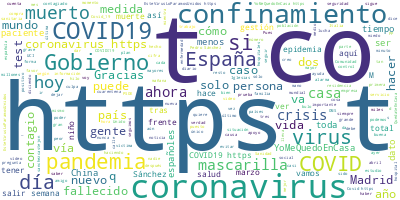

In [71]:
# Label 0
wordcloud.generate(txt_cat0)
wordcloud.to_image()

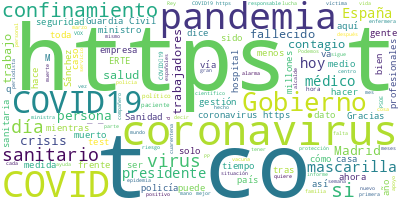

In [72]:
# Label 1
wordcloud.generate(txt_cat1)
wordcloud.to_image()

In [73]:
# Eliminar espacios
def eliminar_espacios(text):
    return  " ".join(text.split())

# Minusculas
def texto_to_lower(text):
  return text.lower()

In [74]:
# Espacios y minusculas
tqdm.pandas()

dataset_train_df["normalized"] = dataset_train_df["text"].progress_apply(lambda x: eliminar_espacios(x))
dataset_train_df["normalized"] = dataset_train_df["normalized"].progress_apply(lambda x: texto_to_lower(x))

dataset_train_df.head()

100%|██████████| 2786/2786 [00:00<00:00, 101197.11it/s]


,tweet_id,text,label,char_len,normalized
0,1275401361073586177,Las / os sanitarias / os no necesitan capas de...,1,256,las / os sanitarias / os no necesitan capas de...
1,1251580665948246023,Las residencias de mayores de Burgos suman 42 ...,0,156,las residencias de mayores de burgos suman 42 ...
2,1244272146265903106,@IreneMontero Utilice el tiempo de confinamien...,0,108,@irenemontero utilice el tiempo de confinamien...
3,1263384060132495360,.@FreseniusKabi dona más de 110.000 mascarilla...,1,194,.@freseniuskabi dona más de 110.000 mascarilla...
4,1250207505252265989,Judy y el confinamiento . Dia 31 . Mona de Pas...,0,260,judy y el confinamiento . dia 31 . mona de pas...


In [75]:
# Tokenizador de tweets
tweet_tokenizer = TweetTokenizer()

def normalizar_tokens(doc):
    # Dividir el documento en palabras
    palabras =  tweet_tokenizer.tokenize(doc)

    # Reemplazar URLs, menciones de Twitter y números por los tokens correspondientes
    for i in range(len(palabras)):
        if palabras[i].startswith("http://") or palabras[i].startswith("https://") or palabras[i].startswith("www."):
            palabras[i] = "URL"
        elif palabras[i].startswith("@"):
            palabras[i] = "MENTION"
        elif palabras[i].isdigit():
            palabras[i] = "NUM"

    # Unir las palabras de nuevo en un documento modificado
    doc_1 = ' '.join(palabras)

    return doc_1

In [76]:
dataset_train_df["normalized"] = dataset_train_df["normalized"].progress_apply(lambda x: normalizar_tokens(x))

 59%|█████▉    | 1649/2786 [00:01<00:00, 1252.87it/s]


KeyboardInterrupt: 

In [ ]:
dataset_train_df.normalized.to_list()

In [ ]:
!python -m spacy download es_core_news_sm

nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

def lematizar_eliminacion_tokens(texto):
    # Procesar el texto con el objeto nlp
    doc = nlp(texto)

    # Lematizar el texto
    lemas = [token.lemma_ for token in doc]

    # Eliminar símbolos de puntuación y stopwords
    tokens_filtrados = [token for token in lemas if token.isalpha() and token.lower() not in es_stopwords]

    # Unir los tokens filtrados en un nuevo texto
    texto_procesado = ' '.join(tokens_filtrados)

    return texto_procesado

In [ ]:
dataset_train_df["preprocessed_text"] = dataset_train_df["normalized"].progress_apply(lambda x: lematizar_eliminacion_tokens(x))

In [ ]:
txt_cat0 = ",".join(dataset_train_df[dataset_train_df.label==0].preprocessed_text.to_list())
txt_cat1 = ",".join(dataset_train_df[dataset_train_df.label==1].preprocessed_text.to_list())

# Label 0
wordcloud.generate(txt_cat0)

wordcloud.to_image()

In [ ]:
# Label 1
wordcloud.generate(txt_cat1)

wordcloud.to_image()

## Tokenización

El texto del dataset no está preparado para ser introducido en un modelo Transformers. Lleva a cabo el proceso de tokenización.

In [ ]:
# IMPORTS
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import evaluate
import matplotlib.pyplot as plt

Selecciona un modelo apropiado para la tarea:

> Recuerda que en la siguiente celda sólo debes asignar un valor a model_name. No añadas más información en la celda.

He decidido escoger este modelo porque estoy trabajando con tweets en español y en especifico el modelo ha sido entrenado con datos laborales, que se acerca mucho al objetivo de la tarea.

In [ ]:
#NO-MODIFY: VARIABLE NAME
model_name = 'dccuchile/bert-base-spanish-wwm-cased'

Puedes continuar con el proceso aquí:

In [ ]:
# Carga tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = Dataset.from_pandas(dataset_train_df)
val_dataset = Dataset.from_pandas(dataset_val_df)
test_dataset = Dataset.from_pandas(dataset_test_df)

# Tokeniza
def preprocess_function(examples):
    # Tokenizar el texto
    return tokenizer(examples['text'], padding="max_length", truncation=True)

In [ ]:
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

## Fine-tuning

Carga el model para ser ajustado posteriormente:



In [ ]:
id2label = {0: "NO_Profesion", 1: "Profesion"}
label2id = {"NO_Profesion": 0, "Profesion": 1}

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)

### Configuracion training_args

Configura los parámetros de entrenamiento del modelo.


>

> Recuerda que en la siguiente celda sólo debes asignar atributos a la variable training_args. No añadas  otras variables en la celda

In [ ]:
#NO-MODIFY: VARIABLE NAME
training_args = TrainingArguments(
    output_dir="modelo_test",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.1,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none"
)


### Métricas de evaluación

Define las métricas de evaluación

In [ ]:
accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1_score_value = f1_score.compute(predictions=predictions, references=labels)["f1"]

    return {
        "accuracy": accuracy_value,
        "f1_score": f1_score_value,
    }



### Ajuste del modelo

Lleva a cabo el ajuste del modelo:

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

In [ ]:
trainer.save_model("output_model_save")

In [ ]:
# Extraemos los logs de entrenamiento
history = pd.DataFrame(trainer.state.log_history)

# A veces los logs pueden tener pasos donde no se evalúa. Filtramos filas con 'loss' y 'eval_loss'
train_loss = history[history['loss'].notna()][['step', 'loss']]
eval_loss = history[history['eval_loss'].notna()][['step', 'eval_loss']]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_loss['step'], train_loss['loss'], label='Training Loss')
plt.plot(eval_loss['step'], eval_loss['eval_loss'], label='Evaluation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluacion

Una vez llevada a cabo el entrenamiento, realiza la evaluación del modelo.

In [ ]:
trainer.evaluate(test_dataset)

## Genera predicciones

Genera predicciones sobre el test set. Recuerda que el archivo que generes y adjuntes al ejercicio debe tener dos columnas:


| id         | label |
|------------|-------|
| 1234567890 | 1     |
| 1234567891 | 0     |
| 1234567892 | 0     |
| 1234567893 | 1     |

- El archivo debe estar en formato **TSV** (separado por tabuladores).
- Debe contener exactamente **dos columnas**: `id` y `label`.
- Es obligatorio incluir la **cabecera**.


In [ ]:
predictions = trainer.predict(test_dataset)

In [ ]:
y_pred = predictions.predictions.argmax(axis=1)
y_true = [x["labels"] for x in test_dataset]